# MlFlow implementation for autogluon
**Objetive:** track and registre autogluon predictors using mlflow

In [79]:
import pandas as pd
import numpy as np
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
import heler_functions as hf
import importlib

try:
    importlib.reload(hf)
except Exception as e: 
    print(f'Error reloading module: {e}')

## Initialize experiment variables

In [ ]:
# init
target_var = "charges"
preset_mode = 'medium_quality'
time_limit = 60 * 10 # 10 minutes in seconds
outlier_drop = True
autogluon_path = f'./{target_var}_autogluon/{preset_mode}'

init_values = {
    'target_var': target_var,
    'preset_mode': preset_mode,
    'time_limit': time_limit,
    'autogluon_path': autogluon_path
}

display(init_values)


{'target_var': 'charges',
 'preset_mode': 'medium_quality',
 'time_limit': 600,
 'autogluon_path': './charges_autogluon/medium_quality'}

# Load Data

In [8]:
# Download data from KaggleHub 
path = kagglehub.dataset_download("mirichoi0218/insurance")
df = pd.read_csv(path + "/insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


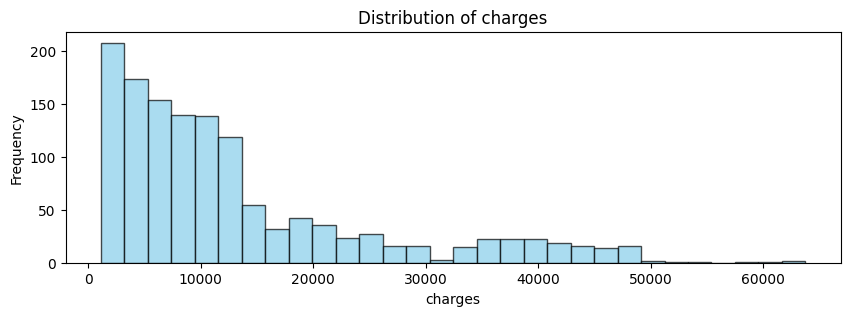

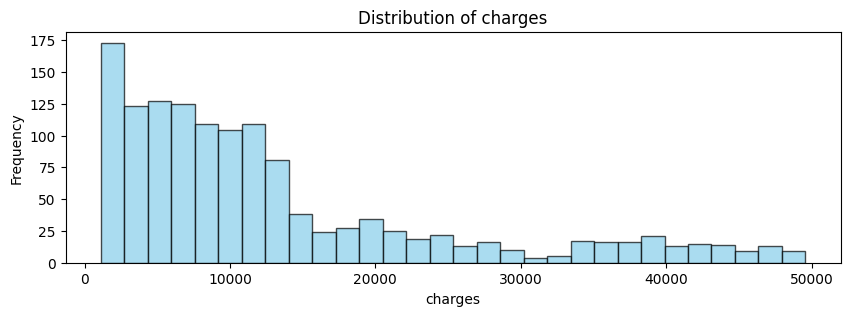

In [ ]:
def get_target_distribution(df, target_var):
    """
    Get the distribution of the target variable.
    """
    plt.figure(figsize=(10, 3))
    plt.hist(df[target_var], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title(f'Distribution of {target_var}')
    plt.xlabel(target_var)
    plt.ylabel('Frequency')
    plt.show()
    
def get_outlier_drop(df):
    df = df.copy()
    df['z_scores'] = (df[target_var] - df[target_var].mean()) / df[target_var].std()
    df['outlier_z'] = np.where(df['z_scores'].abs() > 3, 1, 0)
    df = df[df['outlier_z'] == 0]
    df = df.drop(columns=['z_scores', 'outlier_z'])
    return df

get_target_distribution(df, target_var)
get_target_distribution(get_outlier_drop(df), target_var)

/Users/delfosg/Documents/aoutgluon-mlflow-integration/heler_functions.py:126: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  
/Users/delfosg/Documents/aoutgluon-mlflow-integration/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


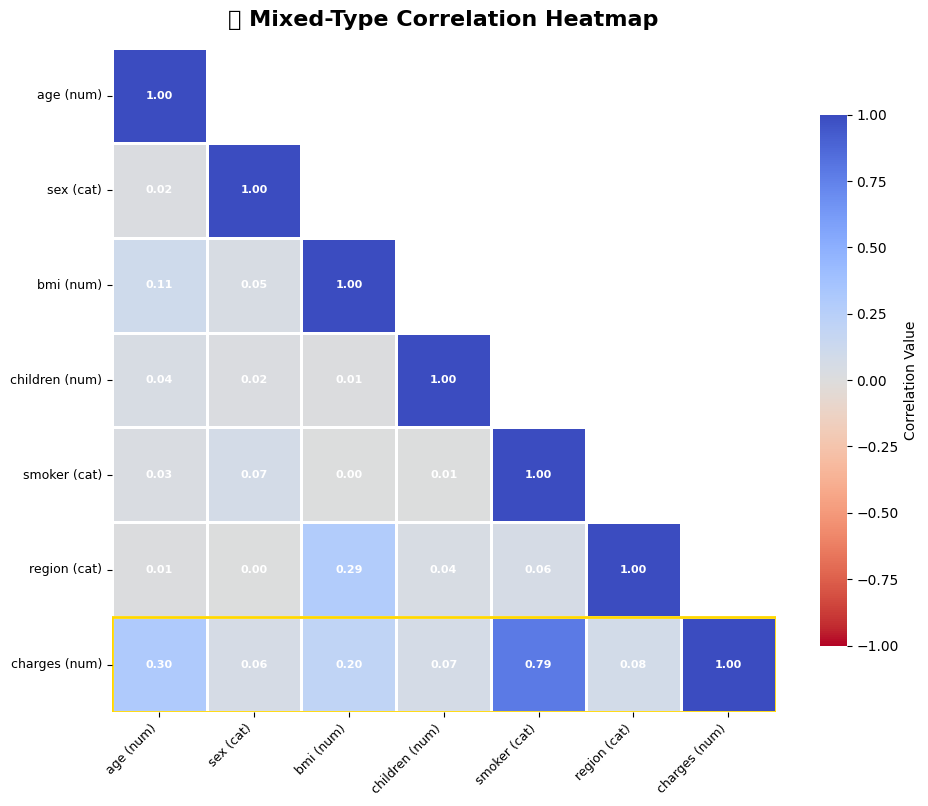

In [80]:
hf.mixed_correlation_heatmap(df, annot=True, encode=False, target=target_var)